In [2]:
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt

In [3]:
maxAcc = 0.0
maxIter = 0
C_Lambda = 0.03
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10
M = 10
PHI = []
IsSynthetic = False

In [4]:
def GetTargetVector(filePath):
    #Generates a vector from the target file
    t = []
    with open(filePath, 'rU') as f:
        reader = csv.reader(f)
        for row in reader:  
            t.append(int(row[0]))
    #print("Raw Training Generated..")
    return t

def GenerateRawData(filePath, IsSynthetic):    
    dataMatrix = [] 
    #reads data line by line and generates a feature matrix of the csv file
    with open(filePath, 'rU') as fi:
        reader = csv.reader(fi)
        for row in reader:
            dataRow = []
            for column in row:
                dataRow.append(float(column))
            dataMatrix.append(dataRow)   
    
    if IsSynthetic == False :
        '''If data contains any features which have 0 values, then the pseudoinverse of that data matrix can not be
        computed hence, we delete those rows with zero values.'''
        dataMatrix = np.delete(dataMatrix, [5,6,7,8,9], axis=1)
    dataMatrix = np.transpose(dataMatrix)     
    #print ("Data Matrix Generated..")
    return dataMatrix


'''Function for generating training, validation and testing target and data. It takes a percentage and 
an index and takes the values accordingly from the rawdata and rawtarget'''
def GenerateTargetAndData(targetData,featureData,percentage,index):
    size = int(math.ceil(len(targetData)*(percentage*0.01)))
    end = index + size
    if(index==0):
        target = targetData[:end]
        dataMatrix = featureData[:,0:end]
    else:
        target = targetData[index+1:end]
        dataMatrix = featureData[:,index+1:end]

    return np.array(target),dataMatrix


def GenerateBigSigma(Data,TrainingPercent,IsSynthetic):
    BigSigma    = np.zeros((len(Data),len(Data)))
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    for i in range(0,len(DataT[0])):
        vct = []
        '''calculates variances of each feature vector'''
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))
    '''Here we do not care about the variances between different feature vector hence, we fill only the diagonal
    elements for the big sigma matrix'''
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]
    '''To magnify the values as they are quite small we do a dot product with 200.'''
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    #print ("BigSigma Generated..")
    return BigSigma

# evaluates the value for generating phi matrix
def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

'''different basis function evaluations'''
# Gaussian basis function
def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

#Multi quadric basis function
def GetRadialBasisMultiquadratic(DataRow,MuRow, BigSigInv):
    phi_x = pow(GetScalar(DataRow,MuRow,BigSigInv)+1,0.5)
    return phi_x

#Inverse basis function
def GetRadialBasisInverse(DataRow,MuRow, BigSigInv):
    phi_x = 1/(pow(GetScalar(DataRow,MuRow,BigSigInv)+1,0.5))
    return phi_x

#Linear basis function
def GetRadialBasisLinear(DataRow,MuRow, BigSigInv):
    phi_x = GetScalar(DataRow,MuRow,BigSigInv)
    return phi_x

#cubic basis function
def GetRadialBasisCubic(DataRow,MuRow, BigSigInv):
    phi_x = pow(GetScalar(DataRow,MuRow,BigSigInv),3)
    return phi_x

#Quintic basis function
def GetRadialBasisQuintic(DataRow,MuRow, BigSigInv):
    phi_x = pow(GetScalar(DataRow,MuRow,BigSigInv),5)
    return phi_x

#thin plate basis function
def GetRadialBasisThinPlate(DataRow,MuRow, BigSigInv):
    r=GetScalar(DataRow,MuRow,BigSigInv)
    phi_x = pow(r,2) + math.log(r)
    return phi_x

# generates phi matrix based on the type of basis function
def GetPhiMatrix(Data, MuMatrix, BigSigma,BasisFunction='gaussian', TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    #takes inverse of big sigma matrix
    BigSigInv = np.linalg.inv(BigSigma)
    if(BasisFunction == 'gaussian'):
         for  C in range(0,len(MuMatrix)):
            for R in range(0,int(TrainingLen)):
                PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    elif(BasisFunction == 'multiquadric'):
         for  C in range(0,len(MuMatrix)):
            for R in range(0,int(TrainingLen)):
                PHI[R][C] = GetRadialBasisMultiquadratic(DataT[R], MuMatrix[C], BigSigInv)
    elif(BasisFunction == 'inverse'):
         for  C in range(0,len(MuMatrix)):
            for R in range(0,int(TrainingLen)):
                PHI[R][C] = GetRadialBasisInverse(DataT[R], MuMatrix[C], BigSigInv)
    elif(BasisFunction == 'linear'):
         for  C in range(0,len(MuMatrix)):
            for R in range(0,int(TrainingLen)):
                PHI[R][C] = GetRadialBasisLinear(DataT[R], MuMatrix[C], BigSigInv)
    elif(BasisFunction == 'cubic'):
         for  C in range(0,len(MuMatrix)):
            for R in range(0,int(TrainingLen)):
                PHI[R][C] = GetRadialBasisCubic(DataT[R], MuMatrix[C], BigSigInv)
    elif(BasisFunction == 'quintic'):
         for  C in range(0,len(MuMatrix)):
            for R in range(0,int(TrainingLen)):
                PHI[R][C] = GetRadialBasisQuintic(DataT[R], MuMatrix[C], BigSigInv)
    elif(BasisFunction == 'thin_plate'):
         for  C in range(0,len(MuMatrix)):
            for R in range(0,int(TrainingLen)):
                PHI[R][C] = GetRadialBasisThinPlate(DataT[R], MuMatrix[C], BigSigInv)            
    #print ("PHI Generated..")
    return PHI

# generates the weights using the design matrix and target values
def GetWeightsClosedForm(PHI, T, Lambda):
    Lambda_I = np.identity(len(PHI[0]))
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI)
    PHI_SQR     = np.dot(PHI_T,PHI)
    '''Lambda here is used to regularize the model'''
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    W           = np.dot(INTER, T)
    ##print ("Training Weights Generated..")
    return W


# generates predicted target values using weights and design matrix
def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y

# calculates Erms from the predicted output and the actual output values
def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

# evaluates the accuracy and rms values for a given set of hyperparameters
def evaluate(M,C_Lambda,BasisFunction,RawData,TrainingData,ValData,TestData):
    kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
    Mu = kmeans.cluster_centers_

    BigSigma     = GenerateBigSigma(RawData, TrainingPercent,IsSynthetic)
    TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma,BasisFunction, TrainingPercent)
    W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
    TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma,BasisFunction, 100) 
    VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma,BasisFunction, 100)

    TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
    VAL_TEST_OUT = GetValTest(VAL_PHI,W)
    TEST_OUT     = GetValTest(TEST_PHI,W)

    TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
    ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
    TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))

    print ("E_rms Training    = " + str(float(TrainingAccuracy.split(',')[1])))
    print ("Accuracy Training =" + str(float(TrainingAccuracy.split(',')[0])))
    print ("E_rms Validation  = " + str(float(ValidationAccuracy.split(',')[1])))
    print ("Accuracy Validation =" + str(float(ValidationAccuracy.split(',')[0])))
    print ("E_rms Testing     = " + str(float(TestAccuracy.split(',')[1])))
    print ("Accuracy Testing =" + str(float(TestAccuracy.split(',')[0])))
    print()
    return TestAccuracy

## Fetch and Prepare Dataset

In [5]:
RawTarget = GetTargetVector('Querylevelnorm_t.csv')
RawData   = GenerateRawData('Querylevelnorm_X.csv',IsSynthetic)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 'U' mode is deprecated
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 'U' mode is deprecated
  


## Prepare Training Data

In [6]:
TrainingTarget,TrainingData = GenerateTargetAndData(RawTarget,RawData,TrainingPercent,0)
print(TrainingTarget.shape)
print(TrainingData.shape)

(55699,)
(41, 55699)


## Prepare Validation Data

In [7]:
ValDataAct,ValData = GenerateTargetAndData(RawTarget,RawData,ValidationPercent,(len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

(6962,)
(41, 6962)


## Prepare Test Data

In [8]:
TestDataAct,TestData = GenerateTargetAndData(RawTarget,RawData,TestPercent,(len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)

(6962,)
(41, 6962)


## Closed Form Solution [Finding Weights using Moore- Penrose pseudo- Inverse Matrix]

### Trying out different basis functions and comparing RMS values

In [9]:
BasisFunctions = ['multiquadric','inverse','gaussian','linear','cubic','quintic','thin_plate']
ErmsArr = []
AccuracyArr = []
for basisFunc in BasisFunctions:
    print('Basis Function used:',basisFunc)
    TestAccuracy = evaluate(M,C_Lambda,basisFunc,RawData,TrainingData,ValData,TestData)
    ErmsArr.append(float(TestAccuracy.split(',')[1]))
    AccuracyArr.append(float(TestAccuracy.split(',')[0]))
    

Basis Function used: multiquadric
E_rms Training    = 0.5501744778851975
Accuracy Training =74.04082658575558
E_rms Validation  = 0.5393514265228088
Accuracy Validation =74.6768170066073
E_rms Testing     = 0.6283333598958549
Accuracy Testing =69.81755494900158

Basis Function used: inverse
E_rms Training    = 0.5496212811228006
Accuracy Training =73.76074974416058
E_rms Validation  = 0.5391363649996613
Accuracy Validation =74.36081585751221
E_rms Testing     = 0.6277990704247892
Accuracy Testing =69.93248096537853

Basis Function used: gaussian
E_rms Training    = 0.5494694067137861
Accuracy Training =73.92233253738846
E_rms Validation  = 0.538428174139098
Accuracy Validation =74.6768170066073
E_rms Testing     = 0.6279788453844335
Accuracy Testing =69.87501795719005

Basis Function used: linear
E_rms Training    = 0.5502176552312726
Accuracy Training =73.88283452126609
E_rms Validation  = 0.5395191340948379
Accuracy Validation =74.77736282677391
E_rms Testing     = 0.6284506576330312

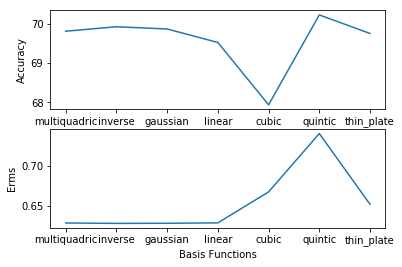

In [12]:
plt.figure(1)               
plt.subplot(211)            
plt.plot(BasisFunctions, AccuracyArr)
plt.ylabel('Accuracy')
plt.xlabel('Basis Functions')
plt.subplot(212)             
plt.plot(BasisFunctions, ErmsArr)
plt.ylabel('Erms')
plt.xlabel('Basis Functions')
plt.show()

In [33]:
# printing the dimensions of all the matrices used
print(Mu.shape)
print(BigSigma.shape)
print(TRAINING_PHI.shape)
print(W.shape)
print(VAL_PHI.shape)
print(TEST_PHI.shape)

(1, 41)
(41, 41)
(55699, 1)
(1,)
(6962, 1)
(6961, 1)


### Trying different values for number of clusters/basis functions and observe how Erms changes

In [15]:
Num_of_basis_functions=[1,2,5,10,15,20,40,50,70,80,100]
ErmsArr = []
AccuracyArr = []
print('Lambda =',C_Lambda)
for M in Num_of_basis_functions:
    TestAccuracy = evaluate(M,C_Lambda,'gaussian',RawData,TrainingData,ValData,TestData)
    ErmsArr.append(float(TestAccuracy.split(',')[1]))
    AccuracyArr.append(float(TestAccuracy.split(',')[0]))
    

Lambda = 0.03
Number of Basis Functions used 1
E_rms Training    = 0.565137868842015
Accuracy Training =74.52198423670085
E_rms Validation  = 0.5543829496065422
Accuracy Validation =75.17954610744039
E_rms Testing     = 0.6402356289634681
Accuracy Testing =70.23416175836805

Number of Basis Functions used 2
E_rms Training    = 0.5627948139796906
Accuracy Training =74.52198423670085
E_rms Validation  = 0.5509381914793687
Accuracy Validation =75.17954610744039
E_rms Testing     = 0.638449311889341
Accuracy Testing =70.23416175836805

Number of Basis Functions used 5
E_rms Training    = 0.552832495074514
Accuracy Training =74.50043986427045
E_rms Validation  = 0.5410872787323588
Accuracy Validation =75.1364550416547
E_rms Testing     = 0.6311320276632661
Accuracy Testing =70.11923574199109

Number of Basis Functions used 10
E_rms Training    = 0.5494694067137861
Accuracy Training =73.92233253738846
E_rms Validation  = 0.538428174139098
Accuracy Validation =74.6768170066073
E_rms Testing  

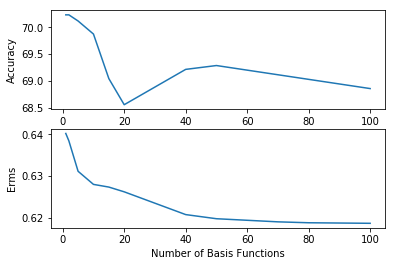

In [17]:
plt.figure(1)               
plt.subplot(211)            
plt.plot(Num_of_basis_functions, AccuracyArr)
plt.ylabel('Accuracy')
plt.xlabel('Num of basis_functions')
plt.subplot(212)             
plt.plot(Num_of_basis_functions, ErmsArr)
plt.ylabel('Erms')
plt.xlabel('Number of Basis Functions')
plt.show()

### Trying out different values for the regulizer and observing how Erms changes

In [19]:
M=1
ErmsArr = []
AccuracyArr = []
print('Number of Basis Functions used =',M)
Lambda = [0.0001,0.01,0.1,0.5,1,5,10,100,1000]
for C_Lambda in Lambda:
    print('Value for regularizer',C_Lambda)
    TestAccuracy = evaluate(M,C_Lambda,'gaussian',RawData,TrainingData,ValData,TestData)
    ErmsArr.append(float(TestAccuracy.split(',')[1]))
    AccuracyArr.append(float(TestAccuracy.split(',')[0]))
    

Number of Basis Functions used = 1
Value for regularizer 0.0001
E_rms Training    = 0.5651378688419794
Accuracy Training =74.52198423670085
E_rms Validation  = 0.5543829534189716
Accuracy Validation =75.17954610744039
E_rms Testing     = 0.6402356058953684
Accuracy Testing =70.23416175836805

Value for regularizer 0.01
E_rms Training    = 0.5651378688419868
Accuracy Training =74.52198423670085
E_rms Validation  = 0.5543829521566545
Accuracy Validation =75.17954610744039
E_rms Testing     = 0.6402356135332975
Accuracy Testing =70.23416175836805

Value for regularizer 0.1
E_rms Training    = 0.5651378688423746
Accuracy Training =74.52198423670085
E_rms Validation  = 0.5543829406814273
Accuracy Validation =75.17954610744039
E_rms Testing     = 0.6402356829691717
Accuracy Testing =70.23416175836805

Value for regularizer 0.5
E_rms Training    = 0.5651378688517864
Accuracy Training =74.52198423670085
E_rms Validation  = 0.5543828896888023
Accuracy Validation =75.17954610744039
E_rms Testing

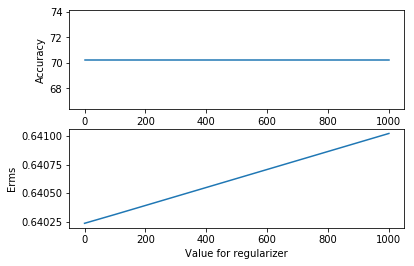

In [21]:
plt.figure(1)               
plt.subplot(211)            
plt.plot(Lambda, AccuracyArr)
plt.ylabel('Accuracy')
plt.xlabel('Value for regularizer')
plt.subplot(212)             
plt.plot(Lambda, ErmsArr)
plt.ylabel('Erms')
plt.xlabel('Value for regularizer')
plt.show()

## Finding Erms on training, validation and test set 

In [28]:
print ('UBITname      = nishimeh')
print ('Person Number = 50291671')
print ('----------------------------------------------------')
print ("------------------LeToR Data------------------------")
print ('----------------------------------------------------')
print ("-------Closed Form with Radial Basis Function-------")
print ('----------------------------------------------------')
print ("Regularizer value, lambda = 0.001, Number of basis functions used= 1, type of basis function used: gaussian")
M=1
C_Lambda=0.001
TestAccuracy = evaluate(M,C_Lambda,'gaussian',RawData,TrainingData,ValData,TestData)

UBITname      = nishimeh
Person Number = 50291671
----------------------------------------------------
------------------LeToR Data------------------------
----------------------------------------------------
-------Closed Form with Radial Basis Function-------
----------------------------------------------------
M = 1 
Lambda = 0.001,
Basis Function used: Gaussian
E_rms Training    = 0.5651378688419847
Accuracy Training =74.52198423670085
E_rms Validation  = 0.5543829533042154
Accuracy Validation =75.17954610744039
E_rms Testing     = 0.6402356065897246
Accuracy Testing =70.23416175836805



## Gradient Descent solution for Linear Regression

In [138]:
print ('----------------------------------------------------')
print ('--------------Please Wait for 2 mins!----------------')
print ('----------------------------------------------------')

----------------------------------------------------
--------------Please Wait for 2 mins!----------------
----------------------------------------------------


In [30]:
#initializing weights
W_Now        = np.dot(10, W)
La           = 2
learningRate = [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4]

print ('Regularizer value, lambda = 0.001, Number of basis functions used= 1, type of basis function used: gaussian')
for lr in learningRate:
    print('learning rate =',lr)
    L_Erms_Val   = []
    L_Erms_TR    = []
    L_Erms_Test  = []
    W_Mat        = []
    for i in range(0,400):
        # adapting weights according to the learning rate
        #print ('---------Iteration: ' + str(i) + '--------------')
        Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
        La_Delta_E_W  = np.dot(La,W_Now)
        Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
        Delta_W       = -np.dot(lr,Delta_E)
        W_T_Next      = W_Now + Delta_W
        W_Now         = W_T_Next
        
        # calculating error and accuracy during the learning process
        #-----------------TrainingData Accuracy---------------------#
        TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
        Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
        L_Erms_TR.append(float(Erms_TR.split(',')[1]))

        #-----------------ValidationData Accuracy---------------------#
        VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
        Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
        L_Erms_Val.append(float(Erms_Val.split(',')[1]))

        #-----------------TestingData Accuracy---------------------#
        TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
        Erms_Test = GetErms(TEST_OUT,TestDataAct)
        L_Erms_Test.append(float(Erms_Test.split(',')[1]))
    print ()

    print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
    print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
    print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

Regularizer value, lambda = 0.001, Number of basis functions used= 1, type of basis function used: gaussian
learning rate = 0.01

E_rms Training   = 0.56515
E_rms Validation = 0.55428
E_rms Testing    = 0.63592
learning rate = 0.05

E_rms Training   = 0.56515
E_rms Validation = 0.55428
E_rms Testing    = 0.63592
learning rate = 0.1

E_rms Training   = 0.56514
E_rms Validation = 0.55428
E_rms Testing    = 0.63592
learning rate = 0.15

E_rms Training   = 0.56514
E_rms Validation = 0.55428
E_rms Testing    = 0.63592
learning rate = 0.2

E_rms Training   = 0.56514
E_rms Validation = 0.55428
E_rms Testing    = 0.63592
learning rate = 0.25

E_rms Training   = 0.56514
E_rms Validation = 0.55428
E_rms Testing    = 0.63591
learning rate = 0.3

E_rms Training   = 0.56514
E_rms Validation = 0.55428
E_rms Testing    = 0.63591
learning rate = 0.35

E_rms Training   = 0.56514
E_rms Validation = 0.55428
E_rms Testing    = 0.63591
learning rate = 0.4

E_rms Training   = 0.56514
E_rms Validation = 0.55

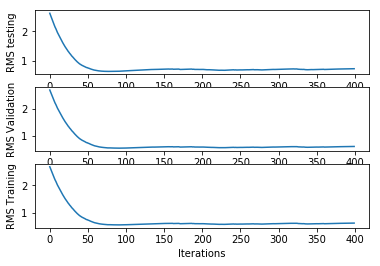

In [37]:
i = [j for j in range(400)]
plt.figure(1)               
plt.subplot(311)            
plt.plot(i, L_Erms_Test)
plt.ylabel('RMS testing')
plt.xlabel('Iterations')
plt.subplot(312)             
plt.plot(i, L_Erms_Val)
plt.ylabel('RMS Validation')
plt.xlabel('Iterations')
plt.subplot(313)             
plt.plot(i, L_Erms_TR)
plt.ylabel('RMS Training')
plt.xlabel('Iterations')
plt.show()